###### TOP

# APPLIED DATA SCIENCE CAPSTONE PROJECT: SETTING UP NEW BUSINESS IN SÃO PAULO CITY


## Table of Contents:

* [Introduction: Background and Business Problem](#Introduction:-Background-and-Business-Problem)

* [Preparing environment (Libraries and functions)](#Preparing-environment-(Libraries-and-functions))

* [Data](#Data)

    * [Getting and Preparing Sao Paulo Subprefectures and Districts-Data](#Getting-Sao-Paulo-Subprefectures-and-Districts-Data)

    * [Preparing Real Estate Dataset](#Preparing-Real-Estate-Dataset)

* [Getting Venues](#Getting-Venues)

* [Venues Clustering](#Venues-Clustering)

---

[*top*](#TOP)
# Introduction: Background and Business Problem

With population more than 12 billion in city area,22 billion considering the urban area, and demographic density of 7,398.26 inhab/km² (2010 Census), Sao Paulo is the largest city of South America.

The city of Sao Paulo's economy is gigantic. Its gross domestic product (GDP) in 2017 was R$699.28 billion, it would be the 47th in the world if it were country, bigger than Egypt and the same size of Israel, for example.

With 535.594 active businesses , there are about 12,500 restaurants with 52 different types of cuisine, in addition, there are about 15 thousand bars in the city, which make it be called as the world's gastronomic capital.

However, open and run a business is not an easy task. In Sao Paulo state, for example, an average of 87,000 companies per year close their doors before 5 years of activity and 29% says the main difficulty in the first year of operation is lack of customers .

From the perspective of an entrepreneur (in addition to other factors) choosing the right place with the right audience can make the difference between business success or failure. It would be interesting if small businesses entrepreneurs could have access to specific analysis regarding characteristics of regions that they intend to start a new business.

This project aims to recommend the best region, regarding venues categories and social status and density of its inhabitants, providing a good tool for decision making when choosing where to start a business.

To better understand the methodology used and its application we'll create assumption and, from those, the business question: Imagine a new entrepreneur who wants to start a new coffee shop in Sao Paulo, near downtown, among medium/high class properties and with a reasonable density population level. Therefore, here is the question to be answered:
> *Where, near downtown, with medium/high class properties and a reasonable density population level would be a good place to start a new fancy coffee shop in Sao Paulo City?*

With our question stated, let's get started!


[*top*](#TOP)
# Preparing environment (Libraries and functions) 

Setting Constants:

In [185]:
import types
from botocore.client import Config
import ibm_boto3
PROJECT_INFO = ("","")
IBM = ('', "", '', '', '')
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 500

Check if some libraries are installed and, if not, install them:

In [186]:
import sys
import subprocess
import pkg_resources

#Check if there is already required pack in our envirenment and if there isn't, installl them
required = {'geopy', 'descartes', 'folium'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing]) #, stdout=subprocess.DEVNULL)

Importing pandas and numpy:

In [187]:
import pandas as pd
import numpy as np
try:
    from pandas import json_normalize
except:
    from pandas.io.json import json_normalize

import requests # library to handle requests
import folium
import json
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from math import sin, cos, sqrt, atan2, radians



#!pip install geopy --upgrade
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


#!pip install geopandas --upgrade
#!pip install descartes --upgrade
#import geopandas

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot') # optional: for ggplot-like style

Let's create functions for a more convenient use along our analysis:

In [188]:
#Function to plot map with locations and markers
def plotMarkerMap(main_latitude, main_longitude, 
                  df_Latitude, df_Longitude, df_Borough, df_Neighborhood, zoom_start = 10, map1 = False):
    # create map using latitude and longitude values
    if not map1: map1 = folium.Map(location=[main_latitude, main_longitude], zoom_start=zoom_start)
    feature_group = folium.FeatureGroup("Locations") 
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df_Latitude, df_Longitude, df_Borough.replace(np.nan,''), df_Neighborhood.replace(np.nan,'')):
        if str(lat) == 'nan' or str(lng) == 'nan':
            print('Geo Coordinates not found for', lat, lng, borough, neighborhood)
            pass
        else:
            comma = lambda n: ", " if n != "" else "No data was found"
            label ='{}{}{}'.format(neighborhood, comma(neighborhood), borough)
            feature_group.add_child(folium.Marker(location=[lat, lng], popup=str(label))) 
    map1.add_child(feature_group)
    return map1

#Function to plot map with locations and circle markers
def plotCircleMarkMap(main_latitude, main_longitude, df_Latitude, 
                      df_Longitude, df_Borough, df_Neighborhood, 
                      fillColor, zoom_start = 10):
    # create map of Toronto using latitude and longitude values
    map1 = folium.Map(location=[main_latitude, main_longitude], zoom_start=zoom_start)
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df_Latitude, df_Longitude, df_Borough, df_Neighborhood):
        if str(lat) == 'nan' or str(lng) == 'nan':
            print('Geo Coordinates not found for', lat, lng, borough, neighborhood)
            pass
        else:
            label = '{}, {}'.format(neighborhood, borough)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color=fillColor,
                fill_opacity=0.7,
                parse_html=False).add_to(map1)  

    return map1



#Function to plot map with locations and circle markers and different colors for kclusters
def plotCircleColorsMap(main_latitude, main_longitude, df_Latitude, 
                      df_Longitude, df_point_1, df_point_2, kclusters, zoom_start = 10):
    # create map of Toronto using latitude and longitude values
    map1 = folium.Map(location=[main_latitude, main_longitude], zoom_start=zoom_start)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_Latitude, df_Longitude, df_point_1, df_point_2):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map1)
    return map1


#Function to plot map with locations and different icon color markers for kclusters
def plotIconColorMarkerMap(main_latitude, main_longitude, 
                      df_Latitude, df_Longitude, df_point_1, df_point_2, kclusters, zoom_start = 10,
                           icon_type = 'cloud', map1 = False):
    # create map using latitude and longitude values
    if not map1: map1 = folium.Map(location=[main_latitude, main_longitude], zoom_start=zoom_start)
    feature_group = folium.FeatureGroup("Locations") 
    icon_color = [
    'beige',
    'red',
    'blue',
    'darkgreen',
    'lightgreen',
    'gray',
    'darkblue',
    'pink',
    'cadetblue',
    'lightred',
    'darkred',
    'darkpurple',
    'purple',
    'green',
    'lightgray',
    'black',
    'orange',
    'lightblue'
    ]
    # add markers to map
    for lat, lon, poi, cluster in zip(df_Latitude, df_Longitude, df_point_1, df_point_2):
        label = str(poi) + ' - Cluster ' + str(cluster)
        folium.Marker(
            location=[lat, lon], popup=str(label), 
            icon=folium.Icon(color=icon_color[cluster-1], icon=icon_type)
        ).add_to(map1)
    return map1


#Function to plot map with locations and icon markers
def plotIconMarkerMap(main_latitude, main_longitude, 
                      df_Latitude, df_Longitude, df_Borough, df_Neighborhood, zoom_start = 10, 
                      icon_color = 'darkgreen', icon_type = 'cloud', map1 = False):
    # create map using latitude and longitude values
    if not map1: map1 = folium.Map(location=[main_latitude, main_longitude], zoom_start=zoom_start)
    feature_group = folium.FeatureGroup("Locations") 
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df_Latitude, df_Longitude, df_Borough.replace(np.nan,''), df_Neighborhood.replace(np.nan,'')):
        if str(lat) == 'nan' or str(lng) == 'nan':
            print('Geo Coordinates not found for', lat, lng, borough, neighborhood)
            pass
        else:
            comma = lambda n: ", " if n != "" else "No data was found"
            label ='{}{}{}'.format(neighborhood, comma(neighborhood), borough)
            folium.Marker(
                location=[lat, lng], popup=str(label), 
                icon=folium.Icon(color=icon_color, icon=icon_type)
            ).add_to(map1)
    return map1

# Function to call brazilian Zip Codes (CEP)

#JSON  -  URL: viacep.com.br/ws/01001000/json/   -   UNICODE: viacep.com.br/ws/01001000/json/unicode/
# Example:  #getLocByCEP('03534000')
#    Result:
#    {
#      "cep": "01001-000",
#      "logradouro": "Praça da Sé",
#      "complemento": "lado ímpar",
#      "bairro": "Sé",
#      "localidade": "São Paulo",
#      "uf": "SP",
#      "unidade": "",
#      "ibge": "3550308",
#      "gia": "1004"
#    }
def getLocByCEP(CEP, format_ = 'json'):
    url = 'https://viacep.com.br/ws/{}/{}/'.format(str(CEP),format_)
    #print(url)
    return requests.get(url).json()

#Function to get geo coordinates with geopy library, by address 
def getCoordinatesGeocode(district, neighborhood = 'SP', postal_code = '', user_agent = 'geocode'):
    loc = None    # initialize variable to None
    # loop until you get the coordinates
    while(loc is None):
        geolocator = Nominatim(user_agent=user_agent)
        loc = geolocator.geocode('{}, {}, {}'.format(postal_code, district, neighborhood))
    return loc.latitude, loc.longitude

#Function to get geo coordinates with Pgeocode library, by postal code 
def getCoordinatesPGeocode(postal_code, country_code = ''):
    geolocator = pgeocode.Nominatim(country_code)
    loc = geolocator.query_postal_code(postal_code)
    return loc['latitude'], loc['longitude']

Let's create some functions strictly related to Foursquare:

In [189]:
# Function to call foursquare actions
# E.g.:
#      If venue, pass venue id = '4f3232e219836c91c7bfde94' # ID of Conca Cucina Italian Restaurant
#      If explorer nearby, pass 'explore'
#      If search, pass 'search' and key word in the last parameter
#      If tips, pass '<venue_id>/tips'   = '4f3232e219836c91c7bfde94/tips'
#      If search user, pass 'users/<user_id>' = 'users/484542633'
#      If trending, 'trending'
def getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT, action = 'explore', search_query='', ACCESS_TOKEN=''):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}&oauth_token={}'.format(
    action,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    search_query, 
    radius, 
    LIMIT, 
    ACCESS_TOKEN, 
    )
    print(url)
    return requests.get(url).json()

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Central Point', 
                  'Central Point Latitude', 
                  'Central Point Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [190]:
# transforms numerical column values in categories
def transfNumCat(column, group_names):
    bins = np.linspace(column.min(), column.max(), len(group_names)+1)
    new_collumn = pd.cut(column, bins, labels=group_names, include_lowest=True )
    return new_collumn

# Sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# determine k using elbow method
def detKByElbowM(X, maxK=10):
    colors = ['b', 'g', 'r']
    markers = ['o', 'v', 's']
    # k means determine k
    distortions = []
    K = range(1,maxK)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Optimal k by Elbow Method')
    print(" Min distortions", min(distortions))
    best_K = K[distortions.index(min(distortions))]
    print(" Best K", best_K)
    plt.show()
    return best_K

def getCoordDistanceInKm(latCentre,longCentre, latMes, longMes):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(latMes)
    lon1 = radians(longMes)
    lat2 = radians(latCentre)
    lon2 = radians(longCentre)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return round(R * c, 2)

[*top*](#TOP)
# Data

Some information about data:

This project will be based on data about districts of Sao Paulo City, obtained automatically (reading HTML) from [Sao Paulo prefecture portal web page](https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php).

In addition, will be used real estate information for districts prices and social status, obtained at [Kaggle](https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019) .

We will make use also of Foursquare API to explore venues, categories, and other possible features inside a district

In order to obtain districts' geo coordinates data, we will need to use [geopy library](https://geopy.readthedocs.io/) to make it possible.

[*top*](#TOP)
## Getting Sao Paulo Subprefectures and Districts Data

As Sao Paulo has hundreds of neighborhoods, we will work only with Subprefectures and Districts and, eventually, looking for neighborhoods inside a specific district.
Let's get from Sao Paulo prefecture Portal page list of districts and other informations:

In [191]:
#In case a ".csv" is already generated from Sao Paulo's prefecture Portal page data, we will use it. Otherwise, we'll get information from Portal
try:
    df_distr_SP = pd.read_csv("sp_distr_geo.csv")
    csv = True
except:
    #url = requests.get("https://pt.wikipedia.org/wiki/Lista_de_distritos_de_S%C3%A3o_Paulo_(estado)").text
    url = "https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php"
    df_distr_SP = pd.read_html(url)
    csv = False

### Cleanning data

In [192]:
#If there isn't a csv, already, we'll clean some data
if not csv:
    df_distr_SP = df_distr_SP[0].replace("TOTAL",np.nan).dropna(subset=['Distritos'], axis=0).reset_index(drop=True)
df_distr_SP.shape

(96, 5)

Getting geocoordinates by district names and add them to our Dataframe:

In [193]:
#If there isn't a csv, already, we'll get distrits's geocoordinates
if not csv:
    L = pd.DataFrame(list(map(getCoordinatesGeocode,df_distr_SP['Distritos'])))
    df_distr_SP['latitude'], df_distr_SP['longitude']= L[0], L[1]
df_distr_SP.head()

,Subprefeituras,Distritos,Área (km²),População (2010),Densidade Demográfica (Hab/km²),latitude,longitude
0,Aricanduva,Aricanduva,660.0,89.622,13.579,-23.578024,-46.511454
1,Aricanduva,Carrão,750.0,83.281,11.104,-23.551530,-46.537791
2,Aricanduva,Vila Formosa,740.0,94.799,12.811,-23.566876,-46.546323
3,Butantã,Butantã,1250.0,54.196,4.336,-23.569131,-46.721874
4,Butantã,Morumbi,1140.0,46.957,4.119,-23.596499,-46.717845


### Normalizing label and data

For better understanding, we will normalize labels and data. 
First we will changes column names (in Portuguese) to English language.
And, as Brazil uses "*dot*" (**.**) as thousand and **comma** as decimal separators, when being pulled from the webpage and converted to dataframe, some data was unformatted. We need to normalize the data:

In [194]:
df_distr_SP.dtypes

Subprefeituras                      object
Distritos                           object
Área (km²)                         float64
População (2010)                   float64
Densidade Demográfica (Hab/km²)    float64
latitude                           float64
longitude                          float64
dtype: object

In [195]:
#If there isn't a csv, already, we'll get distrits's geocoordinates
if not csv:
    # Renanme column name to English language
    df_distr_SP.rename(columns={"Subprefeituras": "Subprefectures", "Distritos": "Districts", 
                       "Área (km²)": "Area (km²)", "População (2010)": "Population (2010)", 
                       "Densidade Demográfica (Hab/km²)": "Demographic Density (Inhab/km²)"}, inplace = True)

    # "Area (km²)" data to reflect the true value
    df_distr_SP['Area (km²)'] = [float(x)/100 for x in df_distr_SP['Area (km²)']]

    # "Population (2010)" data to reflect the true value
    df_distr_SP['Population (2010)'] = [int(x*1000) for x in df_distr_SP['Population (2010)']]

    # "Demographic Density (Inhab/km²)" data to reflect the true value. Needed to check value before change it because data wasn't normalized in the web page (sometimes there was a comma, sometimes there was a point)
    df_distr_SP['Demographic Density (Inhab/km²)'] = [int(x*1000) if (x % round(x))!=0 else int(x) for x in df_distr_SP['Demographic Density (Inhab/km²)']  ]

df_distr_SP.head()

,Subprefectures,Districts,Area (km²),Population (2010),Demographic Density (Inhab/km²),latitude,longitude
0,Aricanduva,Aricanduva,6.6,89622,13579,-23.578024,-46.511454
1,Aricanduva,Carrão,7.5,83281,11104,-23.551530,-46.537791
2,Aricanduva,Vila Formosa,7.4,94798,12811,-23.566876,-46.546323
3,Butantã,Butantã,12.5,54196,4336,-23.569131,-46.721874
4,Butantã,Morumbi,11.4,46957,4119,-23.596499,-46.717845


In [196]:
df_distr_SP.dtypes

Subprefectures                      object
Districts                           object
Area (km²)                         float64
Population (2010)                    int64
Demographic Density (Inhab/km²)      int64
latitude                           float64
longitude                          float64
dtype: object

[*top*](#TOP)
### Preparing Real Estate Dataset

Let's load data related to real estate properties in Sao Paulo city, found at [Kaggle](https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019):

In [197]:
# The code was removed by Watson Studio for sharing.

It's important to note the Real Estate Dataset itself has enough data to make prediction house prices for rent and sales. However, for this project, we just want to get the average price of houses in each district, to make an assumption about their inhabitants' social status.

We will need to remove "/São Paulo" from District column values, to make it available to merge with our main dataset. In addition, although we could use rent prices as a evaluation parameter, we will select just properties on sale:

In [198]:
if not csv:
    #Slicing "District" column values to normalize, letting just District name
    df_rEstate['District'] = [x[:-10] for x in df_rEstate["District"]]

    # Selecting just properties on sale (we don't need on rent)
    df_rEstate = df_rEstate[df_rEstate['Negotiation Type'].isin(["sale"])]
    df_rEstate.head(3)

Now, we will get the average prices of houses on sale, group by district and merge them with our main dataset:

In [199]:
if not csv:
    df_distr_SP = pd.merge(df_distr_SP, df_rEstate.groupby("District").mean()['Price'].round(2), how='left', on=None, left_on='Districts', right_on='District', left_index=False, right_index=False, sort=True)
    # Replace NaN price values with Subprefecture mean 
#    df_distr_SP['Price'] = df_distr_SP['Price'].replace(np.nan,df_distr_SP.groupby(['Subprefectures']).mean()['Price'])
    # Replace remaining NaN price values with dataset mean 
#    df_distr_SP['Price'] = df_distr_SP['Price'].replace(np.nan,df_distr_SP.mean()['Price'])
df_distr_SP.head(3)

,Subprefectures,Districts,Area (km²),Population (2010),Demographic Density (Inhab/km²),latitude,longitude,Price
0,Pinheiros,Alto de Pinheiros,7.7,43117,5600,-23.549549,-46.712155,2455076.07
1,Perus,Anhanguera,33.3,65859,1978,-23.432908,-46.788534,1040805.56
2,Aricanduva,Aricanduva,6.6,89622,13579,-23.578024,-46.511454,295334.75


We need to check if there is any null properties price values. If there is any null value, we will separate them from dataset to latter classify as "Unknown" (even if we assign mean values for "Prices", based in its Subprefecture's member district, it may lead to a misinterpretation, once each district may varies in terms of its inhabitants' social status and/or facilities inside it) and set them to 0.00:

In [200]:
if not csv:
    Unknown_price_df = df_distr_SP[df_distr_SP['Price'].isin([np.nan])]
    Unknown_price_df

In [201]:
if not csv:
        Unknown_price_df["Prop. Class"], Unknown_price_df["Price"]  ='Unknown', 0.00
        Unknown_price_df

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Next, we'll create categories to level districts' houses prices. Let's define it 'Low', 'Low-Medium', 'Medium', 'High-Medium' and 'High' prices:

In [202]:
if not csv:
    # Drop NaN row to work only with districts that have prices
    df_distr_SP = df_distr_SP.dropna(subset=['Price'], axis=0).reset_index(drop=True)

    #Create group names
    group_names = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']
    #Create new column "Prop. Class" and assignt it tranformed values from prices
    df_distr_SP["Prop. Class"] = transfNumCat(df_distr_SP['Price'], group_names)

    #df_distr_SP[df_distr_SP['Districts'].isin(['Mooca'])].head()

In [203]:
if not csv:
    print(df_distr_SP["Prop. Class"].value_counts())

Low            77
Low-Medium      8
Medium          3
High            1
Medium-High     1
Name: Prop. Class, dtype: int64


Most of them are concentrated in a specific level of price. Only two districts are classified as 'High-Medium' and 'High' and three as 'Medium'. Maybe it's interesting to see them in a box plot:

Low            77
Low-Medium      8
Medium          3
High            1
Medium-High     1
Name: Prop. Class, dtype: int64


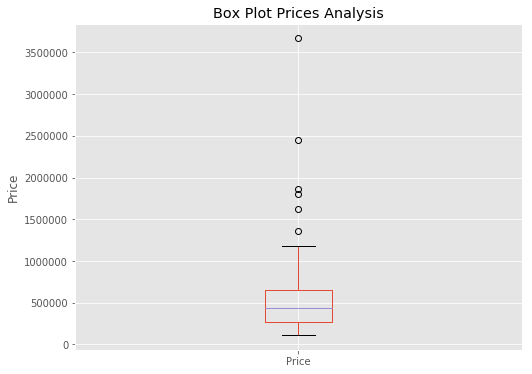

In [204]:
if not csv:
    print(df_distr_SP["Prop. Class"].value_counts())
    df_distr_SP["Price"].plot(kind='box', figsize=(8, 6))
    plt.ylabel("Price")
    plt.title("Box Plot Prices Analysis")
    plt.show()

It seems there are a few outliners. Let's define above 1.0e+06 as "Very-High" and classify all others.

In [205]:
if not csv:
    very_high_distrPrices = df_distr_SP[df_distr_SP.Price >= 1000000]
    very_high_distrPrices["Prop. Class"] = transfNumCat(very_high_distrPrices['Price'], ["Very-High"])
    very_high_distrPrices

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [206]:
if not csv:
    #inLine_distrPrices.drop(columns=['Prop. Class']).reset_index(drop=True)
    inLine_distrPrices = df_distr_SP[df_distr_SP.Price < 1000000]
    inLine_distrPrices["Prop. Class"] = transfNumCat(inLine_distrPrices['Price'],group_names)
    inLine_distrPrices

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Low-Medium     23
Low            23
Medium         21
Medium-High     9
High            5
Name: Prop. Class, dtype: int64


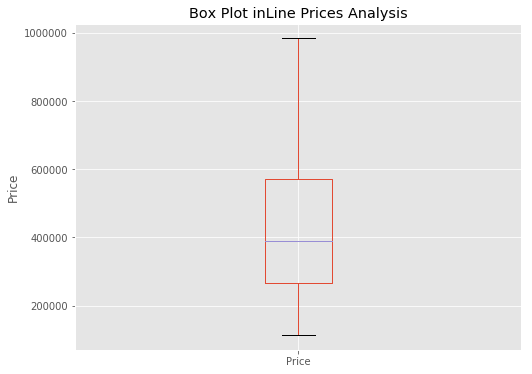

In [207]:
if not csv:
    print(inLine_distrPrices["Prop. Class"].value_counts())
    inLine_distrPrices["Price"].plot(kind='box', figsize=(8, 6))
    plt.ylabel("Price")
    plt.title("Box Plot inLine Prices Analysis")
    plt.show()

Now is better.

In [208]:
if not csv:
    print("\nvery_high_distrPrices: {}, \ninLine_distrPrices: {}, \nUnknown_price_df: {}". format(very_high_distrPrices.shape, inLine_distrPrices.shape, Unknown_price_df.shape))


very_high_distrPrices: (9, 9), 
inLine_distrPrices: (81, 9), 
Unknown_price_df: (6, 9)


In [209]:
if not csv:
    df_distr_SP = pd.concat([very_high_distrPrices, inLine_distrPrices, Unknown_price_df]).reset_index()
    print("Full Dataset shape: ", df_distr_SP.shape)
    print(df_distr_SP["Prop. Class"].value_counts())

Full Dataset shape:  (96, 10)
Low            23
Low-Medium     23
Medium         21
Very-High       9
Medium-High     9
Unknown         6
High            5
Name: Prop. Class, dtype: int64


In [210]:
if not csv:
    group_names = ['1','2','3','4','5']
    df_distr_SP["Density Level"] = transfNumCat(df_distr_SP['Demographic Density (Inhab/km²)'], group_names)
    df_distr_SP.describe()

3    37
2    33
1    12
4    10
5     4
Name: Density Level, dtype: int64


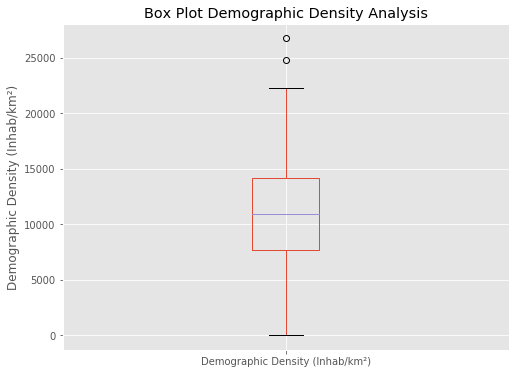

In [211]:
if not csv:
    print(df_distr_SP["Density Level"].value_counts())
    df_distr_SP["Demographic Density (Inhab/km²)"].plot(kind='box', figsize=(8, 6))
    plt.ylabel("Demographic Density (Inhab/km²)")
    plt.title("Box Plot Demographic Density Analysis")
    plt.show()

We need to get the latitude and longitude values of the centroid of Sao Paulo City to get a distance factor for any district and, also, for later use it in graphs and when locating venues in the city:


In [212]:
# Get Sao Paulo downtoen geocoordinates
latSP, longSP = getCoordinatesGeocode('São Paulo')

Finally, we'll calculate distance (in Km) from Sao Paulo's downtown and add it to a new column and categorize it in a other new column: 

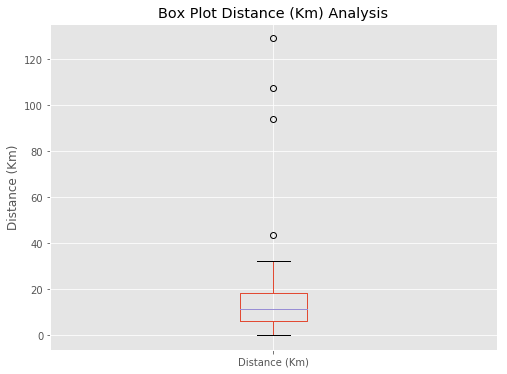

In [213]:
if not csv:
    df_distr_SP["Distance (Km)"] = [getCoordDistanceInKm(latSP, longSP, df_distr_SP['latitude'][i], df_distr_SP['longitude'][i]) for i in range(len(df_distr_SP['latitude']))]

    #Check values in box plot
    df_distr_SP["Distance (Km)"].plot(kind='box', figsize=(8, 6))
    plt.ylabel("Distance (Km)")
    plt.title("Box Plot Distance (Km) Analysis")
    plt.show()

Let's handle outliners:

In [214]:
if not csv:
    outLdistantDistr = df_distr_SP[df_distr_SP["Distance (Km)"] >= 40]
    outLdistantDistr["Distance from Downtown"] = transfNumCat(outLdistantDistr['Distance (Km)'], ['Too Far'])

    inLdistantDistr = df_distr_SP[df_distr_SP["Distance (Km)"] < 40]
    group_dist = ['Very Near', 'Near', 'Somewhat Near', 'Far']
    inLdistantDistr["Distance from Downtown"] = transfNumCat(inLdistantDistr['Distance (Km)'], group_dist)

    df_distr_SP = pd.concat([outLdistantDistr, inLdistantDistr])
    print("Full Dataset shape: ", df_distr_SP.shape)
    print(df_distr_SP["Distance from Downtown"].value_counts())
df_distr_SP.head()

Full Dataset shape:  (96, 13)
Near             37
Very Near        32
Somewhat Near    20
Too Far           4
Far               3
Name: Distance from Downtown, dtype: int64


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,Subprefectures,Districts,Area (km²),Population (2010),Demographic Density (Inhab/km²),latitude,longitude,Price,Prop. Class,Density Level,Distance (Km),Distance from Downtown
54,52,Cidade Ademar,Pedreira,18.700,144317,7717,-22.741347,-46.894846,269376.47,Low,2,93.91,Too Far
69,68,Capela do Socorro,Socorro,0.129,37783,2929,-22.590262,-46.524911,354328.21,Low-Medium,1,107.40,Too Far
77,76,Jaçanã,Tremembé,56.300,197257,3503,-22.957140,-45.547526,545904.47,Medium,1,129.12,Too Far
93,50,Parelheiros,Marsilac,200.000,8258,41,-23.937142,-46.710230,0.00,Unknown,1,43.70,Too Far
0,0,Pinheiros,Alto de Pinheiros,7.700,43117,5600,-23.549549,-46.712155,2455076.07,Very-High,2,8.03,Very Near


Seems to be good.

Exporting to csv for future use, in case any of the data above won't be  available in the future:

In [215]:
#If there isn't a csv, already, we'll create a new csv with datset prepared to be work with 
if not csv:
    try:
        # To save in Clod IBM environment
        # Import the lib
        from project_lib import Project
        sc=''
        project = Project(sc, PROJECT_INFO[0], PROJECT_INFO[1])
        # Save dataframe in object storage as a csv file
        project.save_data("sp_distr_geo.csv", df_distr_SP.to_csv(index=False))
    except:
        df_distr_SP.to_csv("sp_distr_geo.csv")

Let's check how the districts central points are presented in a map:

In [216]:
plotCircleMarkMap(latSP, longSP, df_distr_SP['latitude'], df_distr_SP['longitude'], df_distr_SP['Subprefectures'], df_distr_SP['Districts'], "blue", zoom_start = 11)


Great! Now we have a consistent dataset to start our analysis.


[*top*](#TOP)
### New Business in Sao Paulo

Recalling our requiremnt: a new coffee shop in Sao Paulo, near (or very near) Downtown, among medium/high properties with a reasonable Density Population Level (among '2', '3' e '4' of 5 levels). We'll create a dataframe within these requirements, order by distance in Km:

In [217]:
df_selection = df_distr_SP[df_distr_SP['Distance from Downtown'].isin(['Very Near', 'Near']) & df_distr_SP['Prop. Class'].isin(['Medium-High']) & df_distr_SP['Density Level'].isin(['2', '3', '4'])][['Districts','Density Level','Prop. Class','Distance from Downtown','Distance (Km)', 'latitude','longitude']].sort_values('Distance (Km)')
df_selection

,Districts,Density Level,Prop. Class,Distance from Downtown,Distance (Km),latitude,longitude
50,Mooca,2,Medium-High,Very Near,3.85,-23.560681,-46.597192
35,Ipiranga,2,Medium-High,Very Near,5.11,-23.589273,-46.606162
76,Tatuapé,3,Medium-High,Very Near,5.90,-23.540252,-46.576642
46,Lapa,2,Medium-High,Very Near,7.93,-23.521576,-46.704349
39,Jaguaré,2,Medium-High,Near,11.88,-23.542036,-46.749499
62,Rio Pequeno,3,Medium-High,Near,12.74,-23.568505,-46.756857


Let's plot it:

In [218]:
plotCircleMarkMap(latSP, longSP, df_selection['latitude'], df_selection['longitude'], df_selection['Distance from Downtown'], df_selection['Districts'], "blue", zoom_start = 12)


District like Ipiranga, Tatuapé and Mooca seem to be a better location than the others. But we don't decide about it now. We first analyze all venues in the city to have a better vision of Sao Paulo.

[*top*](#TOP)
# Getting Venues

Now, we'll send a GET request to Foursquare API and check the results.
After that, we'll clean the json and structure the data  into a *pandas* dataframe. First, we'll take a look at venues in the whole city:

In [219]:
results = getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latSP, 
        longSP, 
        radius, 
        LIMIT, 'explore')

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('Total of {} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

nearby_venues.head()

https://api.foursquare.com/v2/venues/explore?&client_id=EAENXZBW3VJNGER2UZV2ZQZYU4TUOL0XYVUP4WLVO3GDVVC1&client_secret=DXSWRTJT3GF3IYWH0Q15YLCUQQYTN40Q3VH0R4IYU3K3YSWG&v=20180604&ll=-23.5506507,-46.6333824&query=&radius=500&limit=100&oauth_token=
Total of 51 venues were returned by Foursquare.


,name,categories,lat,lng
0,Caixa Cultural,Art Gallery,-23.549381,-46.632849
1,Casa de Francisca,Music Venue,-23.548733,-46.634763
2,Kopenhagen,Chocolate Shop,-23.551759,-46.635370
3,Casa da Imagem,Art Museum,-23.548470,-46.632457
4,Marco Zero Sucos e Lanches,Snack Place,-23.549720,-46.633903


Let's see which categories related to Coffee Shop we may explore:

In [220]:
nearby_venues['categories'].unique()

array(['Art Gallery', 'Music Venue', 'Chocolate Shop', 'Art Museum',
       'Snack Place', 'Cultural Center', 'Theater', 'Bakery',
       'University', 'Sake Bar', 'Cosmetics Shop', 'Historic Site',
       'Arts & Crafts Store', 'Gift Shop', 'Japanese Restaurant', 'Gym',
       'Sushi Restaurant', 'Nightclub', 'Business Service',
       'Sporting Goods Shop', 'College Bookstore',
       'Vegetarian / Vegan Restaurant', 'Market', 'Pastry Shop',
       'Miscellaneous Shop', 'Bookstore', 'Juice Bar', 'Jewelry Store',
       'Brazilian Restaurant', 'Café', 'Spa', 'American Restaurant',
       'Music Store', 'Credit Union', 'Restaurant'], dtype=object)

We identified three categories we may use: 'Café','Bakery' and 'Chocolate Shop' (as Chocolate Shops, at least in Brazil, uses to serve and work as Coffee Shops too).
Now, we'll explorer them in the results:

In [221]:
df_cafe_ven = nearby_venues[nearby_venues["categories"].isin(['Café','Bakery','Chocolate Shop'])]
df_cafe_ven.shape

(7, 4)

It seems a single *explore* request won't get much information about Cafés in the city. 
We need to change our strategy and make multiple search requests to Foursquare, each for a specific category related to Coffee Shop. We'll also rise the radius to get more information.

In [222]:
rCafe = getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latSP, 
        longSP, 
        10000, 
        LIMIT, 'search', search_query='café')
rBakery = getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latSP, 
        longSP, 
        10000, 
        LIMIT, 'search', search_query='bakery')
rChocolate = getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latSP, 
        longSP, 
        10000, 
        LIMIT, 'search', search_query='chocolate')

https://api.foursquare.com/v2/venues/search?&client_id=EAENXZBW3VJNGER2UZV2ZQZYU4TUOL0XYVUP4WLVO3GDVVC1&client_secret=DXSWRTJT3GF3IYWH0Q15YLCUQQYTN40Q3VH0R4IYU3K3YSWG&v=20180604&ll=-23.5506507,-46.6333824&query=café&radius=10000&limit=100&oauth_token=
https://api.foursquare.com/v2/venues/search?&client_id=EAENXZBW3VJNGER2UZV2ZQZYU4TUOL0XYVUP4WLVO3GDVVC1&client_secret=DXSWRTJT3GF3IYWH0Q15YLCUQQYTN40Q3VH0R4IYU3K3YSWG&v=20180604&ll=-23.5506507,-46.6333824&query=bakery&radius=10000&limit=100&oauth_token=
https://api.foursquare.com/v2/venues/search?&client_id=EAENXZBW3VJNGER2UZV2ZQZYU4TUOL0XYVUP4WLVO3GDVVC1&client_secret=DXSWRTJT3GF3IYWH0Q15YLCUQQYTN40Q3VH0R4IYU3K3YSWG&v=20180604&ll=-23.5506507,-46.6333824&query=chocolate&radius=10000&limit=100&oauth_token=


In [223]:
# tranform venues into a dataframe
try:
    frames = [pd.json_normalize(rCafe['response']['venues']), pd.json_normalize(rBakery['response']['venues']), pd.json_normalize(rChocolate['response']['venues'])]
    print('Shapes:', pd.json_normalize(rCafe['response']['venues']).shape, pd.json_normalize(rBakery['response']['venues']).shape, pd.json_normalize(rChocolate['response']['venues']).shape)
except:
    frames = [json_normalize(rCafe['response']['venues']), json_normalize(rBakery['response']['venues']), json_normalize(rChocolate['response']['venues'])]
    print('Shapes:', json_normalize(rCafe['response']['venues']).shape, json_normalize(rBakery['response']['venues']).shape, json_normalize(rChocolate['response']['venues']).shape)



df_cafes = pd.concat(frames)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns2 = ['name', 'categories'] + [col for col in df_cafes.columns if col.startswith('location.')] + ['id']
df_cafes_filtered = df_cafes.loc[:, filtered_columns2]

print(df_cafes.shape)
print('{} venues related to Coffee Shop.' .format(df_cafes_filtered.shape[0]))
df_cafes_filtered.head(3)

Shapes: (50, 19) (49, 19) (50, 18)
(149, 19)
149 venues related to Coffee Shop.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,name,categories,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,id
0,Havanna Café,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",Livraria Saraiva,BR,São Paulo,Brasil,2º Piso,171,"[Livraria Saraiva (2º Piso), São Paulo, SP, 01...","[{'label': 'display', 'lat': -23.5519467396333...",-23.551947,-46.634289,Centro,01501-001,SP,5878fbd45a5869013dec9032
1,Café do Páteo,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",Pateo do Collegio,BR,São Paulo,Brasil,NaN,312,"[Pateo do Collegio, São Paulo, SP, 01016-030, ...","[{'label': 'display', 'lat': -23.5479054807141...",-23.547905,-46.632732,NaN,01016-030,SP,4cdeb1c8f8a4a14344e2d8bc
2,Café,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",Teatro Abril,BR,São Paulo,Brasil,NaN,661,"[Teatro Abril, São Paulo, SP, 01317-000, Brasil]","[{'label': 'display', 'lat': -23.5541341220620...",-23.554134,-46.638632,NaN,01317-000,SP,4e3b44e52271d21e86d9e832


Now is better. Let's see how they are located in the map:

In [224]:
plotCircleMarkMap(latSP, longSP, df_cafes_filtered['location.lat'], df_cafes_filtered['location.lng'], df_cafes_filtered['location.address'], df_cafes_filtered['name'], 'green')

The downtown area seems to have already a myriad of Cafés. Let's go back to our district selection and anyze venues inside them:

In [225]:
deep_nearby_selection = getNearbyVenues(df_selection['Districts'], df_selection['latitude'], df_selection['longitude'])
print(deep_nearby_selection.shape)
deep_nearby_selection.head(2)

(223, 7)


,Central Point,Central Point Latitude,Central Point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mooca,-23.560681,-46.597192,Amigos da Dança,-23.561956,-46.597594,Dance Studio
1,Mooca,-23.560681,-46.597192,Carburadores,-23.562262,-46.598312,BBQ Joint


In [226]:
plotCircleMarkMap(latSP, longSP, deep_nearby_selection['Venue Latitude'], 
                      deep_nearby_selection['Venue Longitude'], deep_nearby_selection['Venue'], deep_nearby_selection['Central Point'], 'yellow', 12)

Mooca neighborhood district seem to be a good district to open a new venue. Let's see it in details:


In [227]:
#Get Mooca district information
df_mooca = deep_nearby_selection[deep_nearby_selection["Central Point"].isin(["Mooca"])]
df_mooca['Venue Category'].unique()
print(df_mooca['Venue Category'].value_counts())

Bar                          12
Burger Joint                  5
Mexican Restaurant            3
Gym / Fitness Center          2
Japanese Restaurant           2
Brewery                       1
Bed & Breakfast               1
Coffee Shop                   1
Acai House                    1
Shop & Service                1
Pet Store                     1
Theme Park                    1
Chocolate Shop                1
Pool Hall                     1
Pizza Place                   1
Gym                           1
Chinese Restaurant            1
Bistro                        1
Beach                         1
Dance Studio                  1
Nightclub                     1
Farmers Market                1
Salon / Barbershop            1
Food Truck                    1
Comfort Food Restaurant       1
BBQ Joint                     1
Deli / Bodega                 1
Optical Shop                  1
Drugstore                     1
Middle Eastern Restaurant     1
Snack Place                   1
Theater 

Few Café related venues, still, many other categories venues, very near from Downtown compared all the other of ou selection. Mooca seems to be the right place.

Let's explore it deeply and, search for a suitable place to start our analysis.
We'll make use of a Folium function (***folium.LatLngPopup()***) to get coordinates of a desired position by clicking in it, if we find one.

In [228]:
mooca_map = plotCircleMarkMap(df_mooca['Central Point Latitude'].iloc[0], df_mooca['Central Point Longitude'].iloc[0], df_cafes_filtered['location.lat'], df_cafes_filtered['location.lng'], df_cafes_filtered['location.address'], df_cafes_filtered['name'], 'green', 15)
mooca_map.add_child(folium.LatLngPopup())
mooca_map

Looking at the map, we selected an area near a big avenue. Let's see what is nearby.

In [229]:
new_latitude = -23.5644
new_longitude = -46.5968

mooca_results = getFoursquareInfo(CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        new_latitude, 
        new_longitude, 
        radius, 
        LIMIT)

venues = mooca_results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print('Total of {} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.head()

https://api.foursquare.com/v2/venues/explore?&client_id=EAENXZBW3VJNGER2UZV2ZQZYU4TUOL0XYVUP4WLVO3GDVVC1&client_secret=DXSWRTJT3GF3IYWH0Q15YLCUQQYTN40Q3VH0R4IYU3K3YSWG&v=20180604&ll=-23.5644,-46.5968&query=&radius=500&limit=100&oauth_token=
Total of 82 venues were returned by Foursquare.


,name,categories,lat,lng
0,Jacques Janine,Salon / Barbershop,-23.564752,-46.596138
1,Kopenhagen,Chocolate Shop,-23.562866,-46.597392
2,Sodiê Doces,Dessert Shop,-23.565346,-46.597585
3,Padaria Monte Líbano,Bakery,-23.565305,-46.594933
4,Padaria Jupan,Bakery,-23.565648,-46.597995


In [230]:
df_cafe_ven = nearby_venues[nearby_venues["categories"].isin(['Café','Bakery','Chocolate Shop'])]
print('Total of {} Café related venues were returned by Foursquare in this area.'.format(df_cafe_ven.shape[0]))
df_cafe_ven

Total of 4 Café related venues were returned by Foursquare in this area.


,name,categories,lat,lng
1,Kopenhagen,Chocolate Shop,-23.562866,-46.597392
3,Padaria Monte Líbano,Bakery,-23.565305,-46.594933
4,Padaria Jupan,Bakery,-23.565648,-46.597995
68,Padaria Realeza,Bakery,-23.562509,-46.599373


One Chocolate Shop and three bakeries nearby. It seems a good spot to start a Coffe Shop. Let's see all nearby venues in the map:

In [231]:
plotMarkerMap(new_latitude, new_longitude, 
                  df_cafe_ven['lat'], df_cafe_ven['lng'], df_cafe_ven['name'], df_cafe_ven['categories'], 16)

Let's go deeply through it, and get nearby venues from the venues we found:

In [232]:
deep_nearby_venues = getNearbyVenues(nearby_venues['name'], nearby_venues['lat'], nearby_venues['lng'], radius=500)
print(deep_nearby_venues.shape)
deep_nearby_venues.head(2)

(5465, 7)


,Central Point,Central Point Latitude,Central Point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jacques Janine,-23.564752,-46.596138,Jacques Janine,-23.564752,-46.596138,Salon / Barbershop
1,Jacques Janine,-23.564752,-46.596138,Padaria Monte Líbano,-23.565305,-46.594933,Bakery


In [233]:
print('There are {} uniques categories.'.format(len(deep_nearby_venues['Venue Category'].unique())))

There are 74 uniques categories.


In [234]:
# one hot encoding
deep_mooca_onehot = pd.get_dummies(deep_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add 'Central Point' column back to dataframe
deep_mooca_onehot['Central Point'] = deep_nearby_venues['Central Point'] 

# move 'Central Point' column to the first column
fixed_columns = [deep_mooca_onehot.columns[-1]] + list(deep_mooca_onehot.columns[:-1])
deep_mooca_onehot = deep_mooca_onehot[fixed_columns]

deep_mooca_onehot.head()

,Central Point,Acai House,Argentinian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,...,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Theater,Theme Park,Toy / Game Store,Used Bookstore,Wine Shop,Women's Store
0,Jacques Janine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jacques Janine,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jacques Janine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jacques Janine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jacques Janine,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, it's time to group rows by 'Central Point' and take the mean of the frequency of occurrence of each category

In [235]:
deep_mooca_grouped = deep_mooca_onehot.groupby('Central Point').mean().reset_index()
print("Shape: ", deep_mooca_grouped.shape)
deep_mooca_grouped.head()

Shape:  (81, 75)


,Central Point,Acai House,Argentinian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,...,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Theater,Theme Park,Toy / Game Store,Used Bookstore,Wine Shop,Women's Store
0,1ª Cervejaria da Mooca,0.012658,0.0,0.0,0.012658,0.012658,0.139241,0.012658,0.012658,0.012658,...,0.0,0.012658,0.0,0.0,0.012658,0.0,0.000000,0.0,0.0,0.012658
1,Acqua Academia,0.014706,0.0,0.0,0.014706,0.044118,0.132353,0.000000,0.000000,0.014706,...,0.0,0.014706,0.0,0.0,0.014706,0.0,0.014706,0.0,0.0,0.014706
2,Amigos da Dança,0.015625,0.0,0.0,0.031250,0.031250,0.203125,0.015625,0.015625,0.015625,...,0.0,0.000000,0.0,0.0,0.015625,0.0,0.000000,0.0,0.0,0.000000
3,Azen Corpo E Saude,0.015873,0.0,0.0,0.031746,0.031746,0.206349,0.015873,0.015873,0.015873,...,0.0,0.000000,0.0,0.0,0.015873,0.0,0.000000,0.0,0.0,0.000000
4,Açaí Surf,0.012048,0.0,0.0,0.024096,0.036145,0.132530,0.012048,0.012048,0.012048,...,0.0,0.012048,0.0,0.0,0.012048,0.0,0.000000,0.0,0.0,0.012048


Let's generate a dataframe with the top 10 venues for each Central Point:

In [236]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Central Point']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# Generate a new dataframe
centralPoint_venues_sorted = pd.DataFrame(columns=columns)
centralPoint_venues_sorted['Central Point'] = deep_mooca_grouped['Central Point']

for ind in np.arange(deep_mooca_grouped.shape[0]):
    centralPoint_venues_sorted.iloc[ind, 1:] = return_most_common_venues(deep_mooca_grouped.iloc[ind, :], num_top_venues)

centralPoint_venues_sorted.head()

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1ª Cervejaria da Mooca,Bar,Burger Joint,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Pharmacy,Chocolate Shop,Italian Restaurant,Dance Studio,Mexican Restaurant
1,Acqua Academia,Bar,Gym / Fitness Center,Burger Joint,Bakery,Mexican Restaurant,Spa,Restaurant,Dessert Shop,Pet Store,Japanese Restaurant
2,Amigos da Dança,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Dessert Shop,Shop & Service,Gym,BBQ Joint,Bakery
3,Azen Corpo E Saude,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Shop & Service,Gym,BBQ Joint,Bakery,Beer Bar
4,Açaí Surf,Bar,Gym / Fitness Center,Burger Joint,Restaurant,Japanese Restaurant,Bakery,Pet Store,Brazilian Restaurant,Chocolate Shop,Mexican Restaurant


[*top*](#TOP)
# Venues Clustering

First, we'll define the best K (number of clusters) in a range of 7:

 Min distortions 0.04645259450211982
 Best K 6


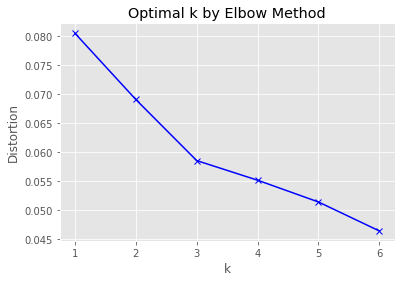

In [237]:
deep_mooca_grouped_clustering = deep_mooca_grouped.drop('Central Point', 1)

# Call function to determine and get best k using elbow method
K = detKByElbowM(deep_mooca_grouped_clustering, 7)

New, we will apply k-means to cluster the district into the of clusters we just get:

In [238]:
# set number of clusters
kclusters = K

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(deep_mooca_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 0, 4, 4, 4, 4, 4, 4], dtype=int32)

Let's put the cluster and the top 10 venues together in a new dataframe:

In [239]:
# add clustering labels
centralPoint_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mooca_nearby_merged = nearby_venues
mooca_nearby_merged.rename(columns={"name": "Central Point"}, inplace = True)

# merge ds to add latitude/longitude for each point
mooca_nearby_merged = mooca_nearby_merged.join(centralPoint_venues_sorted.set_index('Central Point'), on='Central Point')

mooca_nearby_merged.head() # check the last columns!

,Central Point,categories,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jacques Janine,Salon / Barbershop,-23.564752,-46.596138,1,Bar,Gym / Fitness Center,Japanese Restaurant,Spa,Mexican Restaurant,Bakery,Burger Joint,Farmers Market,Middle Eastern Restaurant,Restaurant
1,Kopenhagen,Chocolate Shop,-23.562866,-46.597392,0,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Dessert Shop,Gym,BBQ Joint,Bakery,Beer Bar
2,Sodiê Doces,Dessert Shop,-23.565346,-46.597585,1,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Restaurant,Japanese Restaurant,Burger Joint,Spa,Dessert Shop,Farmers Market
3,Padaria Monte Líbano,Bakery,-23.565305,-46.594933,4,Bar,Japanese Restaurant,Gym / Fitness Center,BBQ Joint,Brazilian Restaurant,Burger Joint,Mexican Restaurant,Bakery,Pet Store,Pizza Place
4,Padaria Jupan,Bakery,-23.565648,-46.597995,1,Bar,Gym / Fitness Center,Bakery,Mexican Restaurant,Japanese Restaurant,Restaurant,Burger Joint,Spa,Dessert Shop,Farmers Market


In [240]:
plotIconColorMarkerMap(new_latitude, new_longitude, mooca_nearby_merged['lat'], 
                      mooca_nearby_merged['lng'], mooca_nearby_merged['Central Point'], mooca_nearby_merged['Cluster Labels'], kclusters,16)

Examining Clusters:

In [241]:
cl0 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 0, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl0

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Kopenhagen,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Dessert Shop,Gym,BBQ Joint,Bakery,Beer Bar
5,Amigos da Dança,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Dessert Shop,Shop & Service,Gym,BBQ Joint,Bakery
7,Carburadores,Bar,Mexican Restaurant,Japanese Restaurant,Burger Joint,Gym,BBQ Joint,Bakery,Gym / Fitness Center,Shop & Service,Dessert Shop
13,Estação Mooca Beer,Bar,Mexican Restaurant,Gym,Japanese Restaurant,Dessert Shop,BBQ Joint,Burger Joint,Bakery,Gym / Fitness Center,Optical Shop
14,La Madre Gourmet,Bar,Burger Joint,Mexican Restaurant,Gym,Gym / Fitness Center,Dessert Shop,Shop & Service,Japanese Restaurant,BBQ Joint,Bakery
17,Kirei Snooker,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Pizza Place,Shop & Service,Gym,BBQ Joint,Bakery
18,Sinete,Bar,Mexican Restaurant,Gym / Fitness Center,Gym,BBQ Joint,Bakery,Japanese Restaurant,Burger Joint,Shop & Service,Dessert Shop
26,Pancho Villa,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Dessert Shop,Shop & Service,Gym,BBQ Joint,Bakery
29,Teatro Arthur Azevedo,Bar,Mexican Restaurant,Burger Joint,Gym / Fitness Center,Japanese Restaurant,Dessert Shop,Restaurant,Gym,BBQ Joint,Bakery
35,Azen Corpo E Saude,Bar,Burger Joint,Mexican Restaurant,Japanese Restaurant,Gym / Fitness Center,Shop & Service,Gym,BBQ Joint,Bakery,Beer Bar


In [242]:
cl1 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 1, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl1

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jacques Janine,Bar,Gym / Fitness Center,Japanese Restaurant,Spa,Mexican Restaurant,Bakery,Burger Joint,Farmers Market,Middle Eastern Restaurant,Restaurant
2,Sodiê Doces,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Restaurant,Japanese Restaurant,Burger Joint,Spa,Dessert Shop,Farmers Market
4,Padaria Jupan,Bar,Gym / Fitness Center,Bakery,Mexican Restaurant,Japanese Restaurant,Restaurant,Burger Joint,Spa,Dessert Shop,Farmers Market
6,Munik Chocolates,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Burger Joint,Restaurant,Japanese Restaurant,Spa,Dessert Shop,Farmers Market
10,Oca do Peixe,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Spa,Restaurant,Burger Joint,Japanese Restaurant,Dessert Shop,Coffee Shop
16,K2 Grill & Beer,Bar,Gym / Fitness Center,Bakery,Mexican Restaurant,Japanese Restaurant,Restaurant,Burger Joint,Spa,Dessert Shop,Farmers Market
23,Bico dos Pneus,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Dessert Shop,Restaurant,Japanese Restaurant,Burger Joint,Spa,Farmers Market
33,Supermercados Yamauchi,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Dessert Shop,Restaurant,Burger Joint,Japanese Restaurant,Spa,Chocolate Shop
37,Acqua Academia,Bar,Gym / Fitness Center,Burger Joint,Bakery,Mexican Restaurant,Spa,Restaurant,Dessert Shop,Pet Store,Japanese Restaurant
38,Novo Hamburguer,Bar,Gym / Fitness Center,Mexican Restaurant,Bakery,Burger Joint,Pizza Place,Restaurant,Japanese Restaurant,Farmers Market,Dessert Shop


In [243]:
cl2 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 2, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl2

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Hambugueria Artesanal,Bar,Burger Joint,Pizza Place,Italian Restaurant,Japanese Restaurant,Gym / Fitness Center,Brazilian Restaurant,Dance Studio,Chocolate Shop,Pharmacy
25,Petcetera Clínica Veterinária,Bar,Burger Joint,Mexican Restaurant,Gym / Fitness Center,Japanese Restaurant,Brazilian Restaurant,Pizza Place,Pharmacy,Dance Studio,Italian Restaurant
31,Zio Pasquale,Bar,Burger Joint,Pizza Place,Mexican Restaurant,Japanese Restaurant,BBQ Joint,Gym / Fitness Center,Pet Store,Dance Studio,Dog Run
40,1ª Cervejaria da Mooca,Bar,Burger Joint,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Pharmacy,Chocolate Shop,Italian Restaurant,Dance Studio,Mexican Restaurant
41,Boteco Seo Joaquim,Bar,Burger Joint,Gym / Fitness Center,Pizza Place,Mexican Restaurant,Japanese Restaurant,BBQ Joint,Pet Store,Dance Studio,Dog Run
45,boteco do sadiq,Bar,Burger Joint,Gym / Fitness Center,Pet Store,Deli / Bodega,Japanese Restaurant,Italian Restaurant,Pizza Place,Dessert Shop,Middle Eastern Restaurant
54,Monte Oliveto,Bar,Burger Joint,Pizza Place,Gym / Fitness Center,Japanese Restaurant,Bakery,Mexican Restaurant,Brazilian Restaurant,Pharmacy,Chocolate Shop
55,Capela Do Frade,Bar,Burger Joint,Pizza Place,Gym / Fitness Center,Japanese Restaurant,Pharmacy,Italian Restaurant,Dance Studio,Mexican Restaurant,Pet Store
56,Rock Bikers Bar,Bar,Burger Joint,Italian Restaurant,Japanese Restaurant,Pizza Place,Gym / Fitness Center,Mexican Restaurant,Dance Studio,Pharmacy,Chocolate Shop
58,Cappela do Frade,Bar,Burger Joint,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Pharmacy,Chocolate Shop,Italian Restaurant,Dance Studio,Mexican Restaurant


In [244]:
cl3 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 3, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl3

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Tortellone Casa das Massas,Bar,Bakery,Mexican Restaurant,Dessert Shop,BBQ Joint,Gym / Fitness Center,Shop & Service,Gym,Comfort Food Restaurant,Optical Shop
64,La Bamba Tex Mex,Dessert Shop,Bakery,Bar,Burger Joint,Mexican Restaurant,Restaurant,Japanese Restaurant,Gym / Fitness Center,Spa,Toy / Game Store
68,Padaria Realeza,Bar,Gym / Fitness Center,Mexican Restaurant,Gym,Dessert Shop,BBQ Joint,Bakery,Japanese Restaurant,Shop & Service,Coffee Shop
70,Instituto Lien,Bar,Dessert Shop,Japanese Restaurant,Gym / Fitness Center,Toy / Game Store,Mexican Restaurant,Farmers Market,BBQ Joint,Bakery,Spa
71,Pianossa Pizzaria,Dessert Shop,Bakery,Bar,Gym / Fitness Center,Mexican Restaurant,BBQ Joint,Japanese Restaurant,Gym,Burger Joint,Market
76,Fujimae Sushi Bar,Dessert Shop,Gym / Fitness Center,Bakery,Bar,Burger Joint,Toy / Game Store,Restaurant,Mexican Restaurant,Spa,Japanese Restaurant
80,Vendinha Das Gerais,Bar,Bakery,Mexican Restaurant,BBQ Joint,Gym / Fitness Center,Dessert Shop,Shop & Service,Gym,Japanese Restaurant,Chocolate Shop


In [245]:
cl4 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 4, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl4

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Padaria Monte Líbano,Bar,Japanese Restaurant,Gym / Fitness Center,BBQ Joint,Brazilian Restaurant,Burger Joint,Mexican Restaurant,Bakery,Pet Store,Pizza Place
8,Gorilla,Bar,Japanese Restaurant,Gym / Fitness Center,Brazilian Restaurant,BBQ Joint,Burger Joint,Bakery,Pet Store,Mexican Restaurant,Restaurant
9,Açaí Surf,Bar,Gym / Fitness Center,Burger Joint,Restaurant,Japanese Restaurant,Bakery,Pet Store,Brazilian Restaurant,Chocolate Shop,Mexican Restaurant
11,Popo's Focaccia,Bar,Brazilian Restaurant,Gym / Fitness Center,Restaurant,Bakery,Burger Joint,Japanese Restaurant,Pet Store,Mexican Restaurant,Spa
12,Bar do Vardemá,Bar,Gym / Fitness Center,Brazilian Restaurant,Burger Joint,Pet Store,Restaurant,Japanese Restaurant,Bakery,BBQ Joint,Supermarket
15,Bar do Juca,Bar,Gym / Fitness Center,Burger Joint,Restaurant,Japanese Restaurant,Bakery,Pet Store,Chocolate Shop,Mexican Restaurant,Dessert Shop
19,Hot Rod Dog,Bar,Brazilian Restaurant,Burger Joint,Gym / Fitness Center,Restaurant,Japanese Restaurant,Bakery,Dessert Shop,Pet Store,Chocolate Shop
20,Brasa & Beer,Bar,Gym / Fitness Center,Brazilian Restaurant,Burger Joint,Pet Store,Restaurant,Japanese Restaurant,Bakery,BBQ Joint,Supermarket
24,Balacotaco,Bar,Gym / Fitness Center,Brazilian Restaurant,Burger Joint,Restaurant,Pet Store,Dessert Shop,Bakery,Japanese Restaurant,Italian Restaurant
27,Quadra Roller Ball,Bar,Gym / Fitness Center,Japanese Restaurant,Burger Joint,BBQ Joint,Bakery,Mexican Restaurant,Brazilian Restaurant,Restaurant,Pharmacy


In [246]:
cl5 = mooca_nearby_merged.loc[mooca_nearby_merged['Cluster Labels'] == 5, mooca_nearby_merged.columns[[0] + list(range(5, mooca_nearby_merged.shape[1]))]]
cl5

,Central Point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Mantra Estética & Spa Urbano,Gym / Fitness Center,Bar,Bakery,Restaurant,Japanese Restaurant,Burger Joint,Dessert Shop,Mexican Restaurant,Spa,Pharmacy
36,Bluefit,Gym / Fitness Center,Bar,Bakery,Dessert Shop,Spa,Restaurant,Burger Joint,Mexican Restaurant,Japanese Restaurant,Pizza Place
66,Ki-Mania Outlet,Gym / Fitness Center,Bar,Bakery,Restaurant,Japanese Restaurant,Burger Joint,Dessert Shop,Mexican Restaurant,Spa,Pharmacy
81,Past' Inno Pastéis,Gym / Fitness Center,Bakery,Burger Joint,Restaurant,Pharmacy,Japanese Restaurant,Dessert Shop,BBQ Joint,Beer Store,Mexican Restaurant


In [247]:
c0 = ['Cluster 0', cl0.isin(['Bakery']).replace(True,1).values.sum(), cl0.isin(['Coffee Shop']).replace(True,1).values.sum(), cl0.isin(['Chocolate Shop']).replace(True,1).values.sum()]
c1 = ['Cluster 1', cl1.isin(['Bakery']).replace(True,1).values.sum(), cl1.isin(['Coffee Shop']).replace(True,1).values.sum(), cl1.isin(['Chocolate Shop']).replace(True,1).values.sum()]
c2 = ['Cluster 2', cl2.isin(['Bakery']).replace(True,1).values.sum(), cl2.isin(['Coffee Shop']).replace(True,1).values.sum(), cl2.isin(['Chocolate Shop']).replace(True,1).values.sum()]
c3 = ['Cluster 3', cl3.isin(['Bakery']).replace(True,1).values.sum(), cl3.isin(['Coffee Shop']).replace(True,1).values.sum(), cl3.isin(['Chocolate Shop']).replace(True,1).values.sum()]
c4 = ['Cluster 4', cl4.isin(['Bakery']).replace(True,1).values.sum(), cl4.isin(['Coffee Shop']).replace(True,1).values.sum(), cl4.isin(['Chocolate Shop']).replace(True,1).values.sum()]
c5 = ['Cluster 5', cl5.isin(['Bakery']).replace(True,1).values.sum(), cl5.isin(['Coffee Shop']).replace(True,1).values.sum(), cl5.isin(['Chocolate Shop']).replace(True,1).values.sum()]
n=0
for c in pd.DataFrame(columns=['Cluster', 'Bakery', 'Café', 'Chocolate Shop']).columns:
        df_cluster_evaluation[c] = [c0[n],c1[n],c2[n],c3[n],c4[n],c5[n]]
        n += 1
df_cluster_evaluation.set_index('Cluster')

,Bakery,Café,Chocolate Shop
Cluster,,,
Cluster 0,17,0,0
Cluster 1,15,1,1
Cluster 2,2,0,7
Cluster 3,7,1,1
Cluster 4,22,0,8
Cluster 5,4,0,0


Clusters **\#0**, **\#1** and **\#4** have a lot of Café related venues. More over, if we look at them, the majority is among 1st. and 5th Most Common Venues.

Cluster **\#5** has only four Central Points, and Bakeries are in 2nd and 3rd Most Common Venues.

Cluster **\#3** has a considerable number of Bakeries in 2nd and 3rd Most Common Venues.

Cluster **\#2** seem to be the most suitable, witht Café related venues only after 6th Most Common Venues.

Comming back to our question:
> *Where, near downtown, with medium/high class properties and a reasonable density population level would be a good place to start a new fancy coffee shop in Sao Paulo City?*

The recomendation is the district of Mooca, in a area where are located the cluster **\#2**

In [248]:
mooca_cluster_2 = mooca_nearby_merged[mooca_nearby_merged["Cluster Labels"]==2]
plotIconColorMarkerMap(new_latitude, new_longitude, mooca_cluster_2['lat'], 
                      mooca_cluster_2['lng'], mooca_cluster_2['Central Point'], mooca_cluster_2['Cluster Labels'], 1,16)

---

# Conclusion

 With quantitative information, we could create qaulitative data, which helpd us to to visualize and define some potencial answers to our question.
 
 After get information about venues from Foursquare and create a map with them, we could have a sense about how businesses are setted in a potencial area.
 
 Finally, we clustered these vanues to get more information and have a clear view about businesses in the district and, analising the data, we could define the most suitable area to start a specific business.